In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

covid_pa_confirmed_cumulative = pd.read_csv("covid_pa_confirmed_cumulative_data.csv")

covid_pa_confirmed_cumulative

,Unnamed: 0,geo_value,signal,time_value,issue,lag,missing_value,missing_stderr,missing_sample_size,value,stderr,sample_size,geo_type,data_source
0,0,pa,confirmed_cumulative_num,2020-01-22,2020-05-14,113,0,5,5,0.0,NaN,NaN,state,jhu-csse
1,0,pa,confirmed_cumulative_num,2020-01-23,2020-05-14,112,0,5,5,0.0,NaN,NaN,state,jhu-csse
2,0,pa,confirmed_cumulative_num,2020-01-24,2020-05-14,111,0,5,5,0.0,NaN,NaN,state,jhu-csse
3,0,pa,confirmed_cumulative_num,2020-01-25,2020-05-14,110,0,5,5,0.0,NaN,NaN,state,jhu-csse
4,0,pa,confirmed_cumulative_num,2020-01-26,2020-05-14,109,0,5,5,0.0,NaN,NaN,state,jhu-csse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,0,pa,confirmed_cumulative_num,2022-06-04,2022-06-05,1,0,5,5,2932186.0,NaN,NaN,state,jhu-csse
865,0,pa,confirmed_cumulative_num,2022-06-05,2022-06-06,1,0,5,5,2932186.0,NaN,NaN,state,jhu-csse
866,0,pa,confirmed_cumulative_num,2022-06-06,2022-06-07,1,0,5,5,2934508.0,NaN,NaN,state,jhu-csse
867,0,pa,confirmed_cumulative_num,2022-06-07,2022-06-08,1,0,5,5,2934508.0,NaN,NaN,state,jhu-csse


In [3]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [4]:
data = pd.read_csv("covid_pa_confirmed_data_7d.csv")
data['time_value'] = pd.to_datetime(data['time_value'], format='%Y-%m-%d')

data = data.set_index("time_value")
data = data.asfreq('D')
data = data.sort_index()
data

,Unnamed: 0,geo_value,signal,issue,lag,missing_value,missing_stderr,missing_sample_size,value,stderr,sample_size,geo_type,data_source
time_value,,,,,,,,,,,,,
2020-02-20,0,pa,confirmed_7dav_incidence_num,2021-04-01,406,0,0,0,0.000000,NaN,NaN,state,jhu-csse
2020-02-21,0,pa,confirmed_7dav_incidence_num,2021-04-01,405,0,0,0,0.000000,NaN,NaN,state,jhu-csse
2020-02-22,0,pa,confirmed_7dav_incidence_num,2021-04-01,404,0,0,0,0.000000,NaN,NaN,state,jhu-csse
2020-02-23,0,pa,confirmed_7dav_incidence_num,2021-04-01,403,0,0,0,0.000000,NaN,NaN,state,jhu-csse
2020-02-24,0,pa,confirmed_7dav_incidence_num,2021-04-01,402,0,0,0,0.000000,NaN,NaN,state,jhu-csse
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-04,0,pa,confirmed_7dav_incidence_num,2022-06-05,1,0,5,5,3551.714286,NaN,NaN,state,jhu-csse
2022-06-05,0,pa,confirmed_7dav_incidence_num,2022-06-06,1,0,5,5,3551.714286,NaN,NaN,state,jhu-csse
2022-06-06,0,pa,confirmed_7dav_incidence_num,2022-06-07,1,0,5,5,3883.428571,NaN,NaN,state,jhu-csse


In [5]:
end_train = '2022-01-01'
end_validation = '2022-05-01'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2020-02-20 00:00:00 --- 2022-01-01 00:00:00  (n=682)
Dates validacion : 2022-01-01 00:00:00 --- 2022-05-01 00:00:00  (n=121)
Dates test       : 2022-05-01 00:00:00 --- 2022-06-08 00:00:00  (n=39)


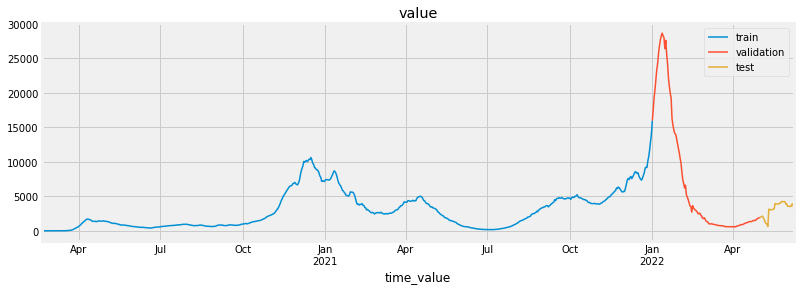

In [6]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_train['value'].plot(ax=ax, label='train')
data_val['value'].plot(ax=ax, label='validation')
data_test['value'].plot(ax=ax, label='test')
ax.set_title('value')
ax.legend()

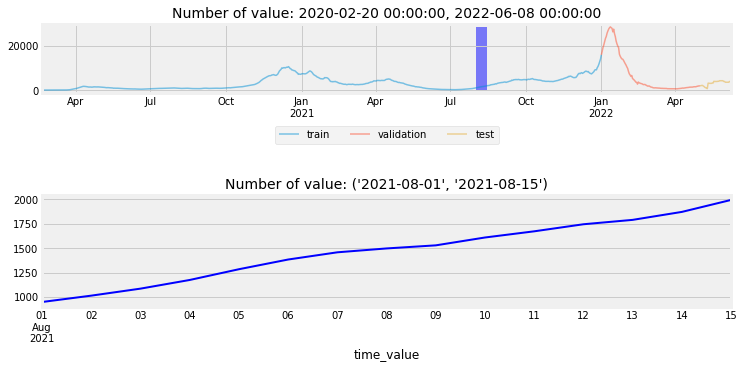

In [7]:
#  Plot time series with zoom
# ==============================================================================
zoom = ('2021-08-01','2021-08-15')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data_train['value'].plot(ax=main_ax, label='train', alpha=0.5)
data_val['value'].plot(ax=main_ax, label='validation', alpha=0.5)
data_test['value'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(data['value'])
max_y = max(data['value'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

data.loc[zoom[0]: zoom[1]]['value'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Number of value: {data.index.min()}, {data.index.max()}', fontsize=14)
zoom_ax.set_title(f'Number of value: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [8]:
# Interactive plot of time series
# ==============================================================================
data.loc[:end_train, 'partition'] = 'train'
data.loc[end_train:end_validation, 'partition'] = 'validation'
data.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data.reset_index(),
    x      = 'time_value',
    y      = 'value',
    color  = 'partition',
    title  = 'Number of value',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

data=data.drop(columns='partition')

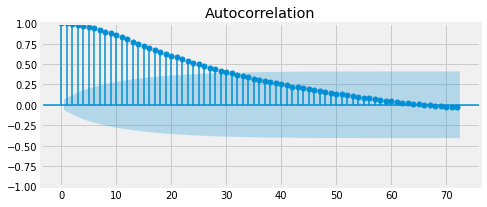

In [9]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data['value'], ax=ax, lags=72)
plt.show()

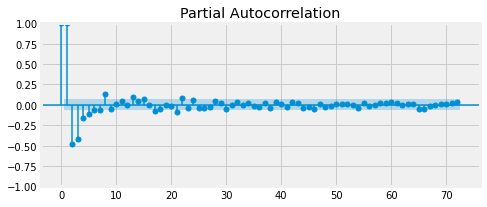

In [10]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data['value'], ax=ax, lags=72, method='ywm')
plt.show()

In [11]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.loc[:end_validation, 'value'], # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False ,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

loop lags_grid:   0%|                                               | 0/4 [00:00<?, ?it/s]

Number of models compared: 48


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [03:55<00:00, 58.96s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 17840832.982576672



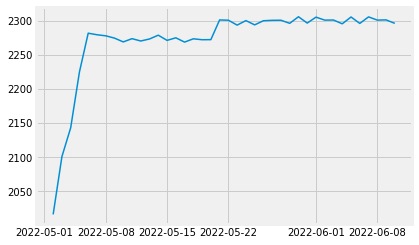

In [12]:
pre = forecaster.predict(steps=40)
plt.plot(pre, label='prediction')

In [13]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.784083e+07,0.1,10.0,500.0
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.792833e+07,0.1,10.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.799680e+07,0.1,10.0,100.0
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.807662e+07,0.1,10.0,100.0
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.848998e+07,0.1,3.0,100.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.856609e+07,0.1,3.0,500.0
47,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.864363e+07,0.1,10.0,500.0
46,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.878471e+07,0.1,10.0,100.0
45,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.879847e+07,0.1,5.0,500.0
44,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.880329e+07,0.1,5.0,100.0


In [14]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['value'],
    initial_train_size = len(data.loc[:end_validation]),
    fixed_train_size   = False,
    steps      = 7,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 857048.8931566554


In [15]:
predictions

,pred
2022-05-02,2016.027100
2022-05-03,2100.828125
2022-05-04,2143.119141
2022-05-05,2224.976318
2022-05-06,2281.872314
2022-05-07,2279.575439
2022-05-08,2278.028076
2022-05-09,994.432983
2022-05-10,993.592712
2022-05-11,1004.832458


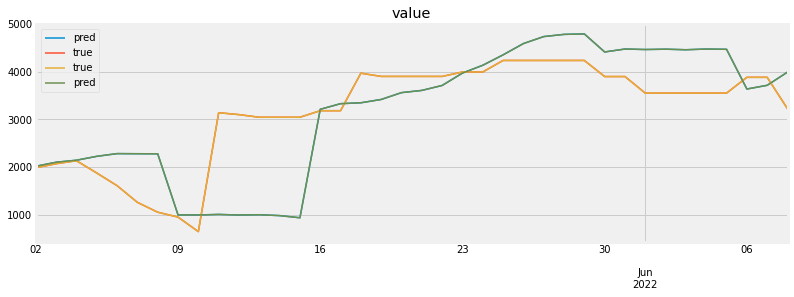

In [16]:
predictions['true'] = data['value']


# Plot predictions
# ==============================================================================
# plot the predictions
fig, ax = plt.subplots(figsize=(12, 4))
predictions.plot(ax=ax, label='predictions')
predictions['true'].plot(ax=ax)
predictions['pred'].plot(ax=ax)
ax.set_title('value')
ax.legend()


    

In [17]:
# test day 2022-06-09-2020-06-15
test_day = pd.DataFrame(columns=['time_value','value'])
test_day.time_value = pd.date_range(start='2022-04-01',end='2022-06-15')

# use the forecaster to predict the value of the test day
# Backtesting
# # ==============================================================================
# metric, predictions = backtesting_forecaster(
#     forecaster = forecaster,
#     y          = test_day['value'],
#     initial_train_size = len(test_day),
#     fixed_train_size   = False,
#     steps      = 7,
#     refit      = False,
#     metric     = 'mean_squared_error',
#     verbose    = False # Change to True to see detailed information
#     )


In [18]:
predictions
print(mean_squared_error(predictions['true'], predictions['pred']))

NameError: name 'mean_squared_error' is not defined

In [ ]:
# Interactive plot of predictions
# ==============================================================================
data_plot = pd.DataFrame({
                'test': data_test['value'],
                'prediction': predictions['pred'],
                 })
data_plot.index.name = 'time_value'

fig = px.line(
    data_frame = data_plot.reset_index(),
    x      = 'time_value',
    y      = data_plot.columns,
    title  = 'Number of value',
    width  = 900,
    height = 500
    )

fig.update_xaxes(rangeslider_visible=True)
fig.show()

>expected=4237.7, predicted=4190.2
>expected=4237.7, predicted=4244.7
>expected=3899.9, predicted=4157.1
>expected=3899.9, predicted=3727.7
>expected=3551.7, predicted=3854.5
>expected=3551.7, predicted=3280.6
>expected=3551.7, predicted=3488.8
>expected=3551.7, predicted=3623.3
>expected=3551.7, predicted=3591.5
>expected=3883.4, predicted=3556.3
>expected=3883.4, predicted=4008.5
>expected=3223.4, predicted=3893.9
MAE: 196.227


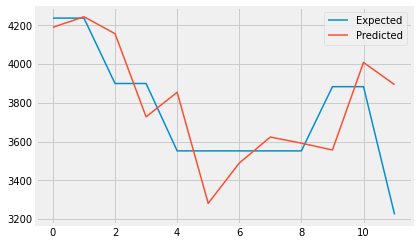

In [ ]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# load the dataset
series = read_csv('covid_pa_confirmed_data_7d.csv', header=0, index_col=0)
values = series.value
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# load the dataset
series = read_csv('covid_pa_confirmed_data_7d.csv', header=0, index_col=0)
values = np.array(series.value)
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
import covidcast
from datetime import date
newvalue = values.copy()
for i in range(1,7):
    row = newvalue[-6:].flatten()
    yhat = model.predict(asarray([row]))
    print("days = ", i, "prediction = ", yhat)
    newvalue = np.append(newvalue, yhat)

newdata = pd.DataFrame()
newdata['time_value'] = pd.date_range(start='2022-06-09',end = '2022-06-14', freq='D')

newdata['prediction'] = newvalue[-6:]
newdata['actual'] = 0
data_new = covidcast.signal("jhu-csse", "confirmed_7dav_incidence_num", date(2022,6,9), date(2022, 6,14),
                        "state", "pa")
data_new = data_new.set_index("time_value")
# set the newdata['actual'] to the actual data
newdata['actual'] = np.array(data_new['value'])
# row = values[-6:].flatten()
# # make a one-step prediction
# yhat = model.predict(asarray([row]))
# print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

days =  1 prediction =  [2985.1213]
days =  2 prediction =  [3004.9712]
days =  3 prediction =  [2818.9265]
days =  4 prediction =  [2668.242]
days =  5 prediction =  [2572.6748]
days =  6 prediction =  [2503.8728]


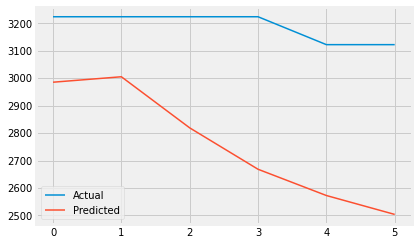

In [ ]:
# plot the actual vs predicted
pyplot.plot(newdata.index,newdata['actual'], label='Actual')
pyplot.plot(newdata.index,newdata['prediction'], label='Predicted')
pyplot.legend()
